In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [5]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [6]:
def get_melted_pi_tpm_table(ver='poder', min_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)

    # get predominant transcripts per sample
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    if min_cpm:
        df = df.loc[df.tpm >= min_cpm]
        
    return df

In [10]:
# get predominant transcripts for poder
df = get_melted_pi_tpm_table('poder', 5)

df = df.sort_values(by='pi', ascending=False)
df = df.drop_duplicates(subset=['gid', 'sample'], keep='first')

# count the number of unique predominant transcripts per gene
# across individuals (ie not across populations)~!
temp = df[['gid', 'tid']].drop_duplicates()
temp = temp.groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
temp.head()

,gid,n_t
0,ENSG00000000419.14,1
1,ENSG00000000938.13,1
2,ENSG00000001036.14,1
3,ENSG00000001497.18,1
4,ENSG00000001630.18,1


In [11]:
# get predominant transcripts for v47
gc_df = get_melted_pi_tpm_table('v47', 5)

gc_df = gc_df.sort_values(by='pi', ascending=False)
gc_df = gc_df.drop_duplicates(subset=['gid', 'sample'], keep='first')

# count the number of unique predominant transcripts per gene
# across individuals (ie not across populations)~!
gc_temp = gc_df[['gid', 'tid']].drop_duplicates()
gc_temp = gc_temp.groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
gc_temp.head()

,gid,n_t
0,ENSG00000000419.14,1
1,ENSG00000000938.13,2
2,ENSG00000001036.14,1
3,ENSG00000001630.18,1
4,ENSG00000002330.14,1


In [14]:
# plot the number of predominant transcripts / gene in gc vs. poder
# only use genes where both were detected
predom_df = temp.merge(gc_temp, how='inner',
                       on='gid',
                       suffixes=('_poder', '_v47'))

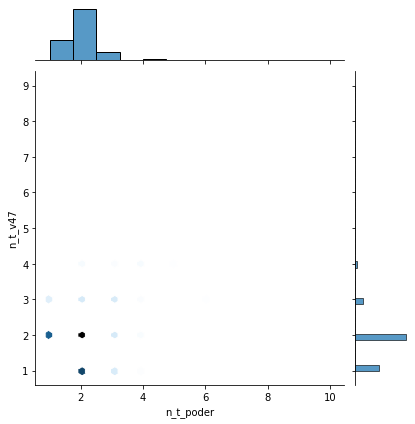

In [21]:
temp3 = predom_df.loc[(predom_df.n_t_poder!=1)|(predom_df.n_t_v47!=1)]
sns.jointplot(temp3, x='n_t_poder', y='n_t_v47', kind='hex')

In [22]:
predom_df['more_predom_poder'] = predom_df.n_t_poder>predom_df.n_t_v47
predom_df[['more_predom_poder', 'gid']].groupby('more_predom_poder').nunique().rename({'gid':'n_genes'},axis=1)

,n_genes
more_predom_poder,
False,6107
True,539


## Compare the pi values of predominant isoforms per gene in v47 and gencode


In [ ]:
# get predominant transcripts for v47
gc_df = get_melted_pi_tpm_table('v47', 5)

gc_df = gc_df.sort_values(by='pi', ascending=False)
gc_df = gc_df.drop_duplicates(subset=['gid', 'sample'], keep='first')
